In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import re
from tqdm.notebook import tqdm
import requests
import datetime
import time
from collections import Counter
from random import uniform, randint
import warnings

warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from natasha import (Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger,
                     NewsNERTagger, Doc)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             f1_score, classification_report)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
import tensorflow as tf
import tensorflow_addons as tfa
import keras

In [2]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'

conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

In [3]:
def data_import_from_db(table_name, conn_string):
    db = create_engine(conn_string) 
    conn = db.connect() 
    conn.autocommit = True
    df = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)
    conn.close()
    return df

# Setup

In [4]:
def plot_cm(y, pred):
    fig, ax = plt.subplots(figsize=(8, 5))
    cm = confusion_matrix(y, pred)
    cmp = ConfusionMatrixDisplay(
        cm, display_labels=[0, 1, 2])
    cmp.plot(ax=ax)
    plt.show()

In [5]:
additional_stopwords = [
    'которых', 'которые', 'твой', 'которой', 'которого', 'сих', 'ком', 'свой',
    'твоя', 'этими', 'слишком', 'нами', 'всему', 'будь', 'саму', 'чаще',
    'ваше', 'сами', 'наш', 'затем', 'самих', 'наши', 'ту', 'каждое', 'мочь',
    'весь', 'этим', 'наша', 'своих', 'оба', 'который', 'зато', 'те', 'этих',
    'вся', 'ваш', 'такая', 'теми', 'ею', 'которая', 'нередко', 'каждая',
    'также', 'чему', 'собой', 'самими', 'нем', 'вами', 'ими', 'откуда',
    'такие', 'тому', 'та', 'очень', 'сама', 'нему', 'алло', 'оно', 'этому',
    'кому', 'тобой', 'таки', 'твоё', 'каждые', 'твои', 'нею', 'самим', 'ваши',
    'ваша', 'кем', 'мои', 'однако', 'сразу', 'свое', 'ними', 'всё', 'неё',
    'тех', 'хотя', 'всем', 'тобою', 'тебе', 'одной', 'другие', 'само', 'эта',
    'самой', 'моё', 'своей', 'такое', 'всею', 'будут', 'своего', 'кого',
    'свои', 'мог', 'нам', 'особенно', 'её', 'самому', 'наше', 'кроме',
    'вообще', 'вон', 'мною', 'никто', 'это'
]

stop_words = stopwords.words('russian') + additional_stopwords

In [2]:
# Natasha <3
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [2]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)


def del_stopwords(text):
    clean_tokens = tuple(
        map(lambda x: x if x not in stop_words else '', word_tokenize(text)))
    res_text = ' '.join(clean_tokens)
    return res_text


def lemmatize(text):
    text = Doc(text)
    text.segment(segmenter)
    text.tag_morph(morph_tagger)
    for token in text.tokens:
        token.lemmatize(morph_vocab)
    text.tag_ner(ner_tagger)
    for span in text.spans:
        span.normalize(morph_vocab)
    return ' '.join([token.lemma for token in text.tokens])

In [3]:
def preprocess_and_save(df, save_name):
    txt_lst = []
    txts = df.body.copy()

    for text in tqdm(txts):
        text = prepare_text(text)
        text = del_stopwords(text)
        text = lemmatize(text)
        txt_lst.append(text)
    
    # Save locally file with preprocessed texts (for convenience)
    df_safe = pd.concat(
        [df, pd.DataFrame(txt_lst, columns=['text_clear'])], axis=1)

    df_safe.to_csv(f'texts_{save_name}.csv', index=False)

In [4]:
def define_classes(df, main_col, class_col, p=0.05):
    df_ret = df.copy()

    q_l = df_ret[main_col].quantile(p)
    q_u = df_ret[main_col].quantile(1 - p)

    df_ret[class_col] = 1
    df_ret.loc[df_ret[main_col] <= q_l, class_col] = 0
    df_ret.loc[df_ret[main_col] >= q_u, class_col] = 2

    print(df_ret[class_col].value_counts())
    
    return df_ret

# Model for the companies

In [20]:
df_comp = data_import_from_db('companies_trade', conn_string)

## Preprocessing

In [21]:
preprocess_and_save(df_comp, 'comp')

  0%|          | 0/7267 [00:00<?, ?it/s]

In [6]:
df_comp = pd.read_csv('texts_comp.csv')

for i, text in enumerate(df_comp.text_clear):
    df_comp.loc[i, 'text_clear'] = prepare_text(text).strip()

In [7]:
df_comp = define_classes(df_comp, 'price_diff_percent', 'price_diff_cat', 0.05)

price_diff_cat
1    6539
0     364
2     364
Name: count, dtype: int64


## Model

In [8]:
texts = df_comp['text_clear']
labels = df_comp['price_diff_cat']

X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=labels)

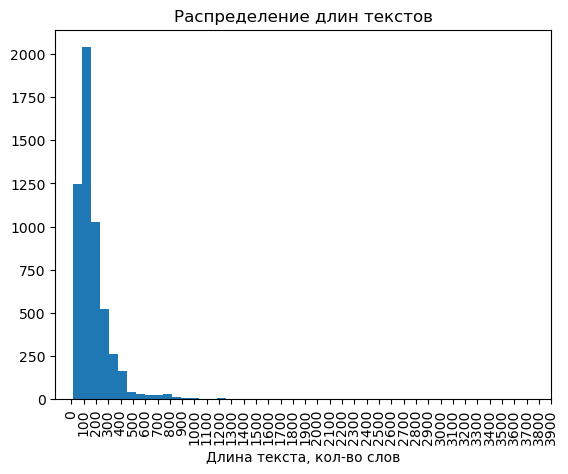

In [9]:
pd.Series([len(str(i).split()) for i in X_train]).hist(bins=40)

plt.xticks(np.arange(0, 4000, 100), rotation='vertical')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста, кол-во слов')
plt.grid()
plt.show()

In [10]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 500 # dimension of word embeddings
lstm_units = 32 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [11]:
# Save tokenizer for further usage in production
with open('tokenizers/comp_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))

In [24]:
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(clipvalue=0.7),
              metrics=[tfa.metrics.F1Score(num_classes=num_classes)])

scheduler = keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=6e-5, decay_rate=0.85, decay_steps=100)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          5000000   
                                                                 
 lstm (LSTM)                 (None, 32)                68224     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 5068323 (19.33 MB)
Trainable params: 5068323 (19.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights = {i: weight for i, weight in enumerate(weights)}

print(weights)

{0: 6.654761904761905, 1: 0.3704440026507621, 2: 6.654761904761905}


In [26]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=6,
          callbacks=[scheduler],
          class_weight=weights,
          validation_data=(X_test, y_test))

Epoch 1/6
171/171 [==============================] - 99s 556ms/step - loss: 1.0967 - f1_score: 0.3084 - val_loss: 1.0727 - val_f1_score: 0.3457 - lr: 6.0000e-05
Epoch 2/6
171/171 [==============================] - 92s 540ms/step - loss: 1.0800 - f1_score: 0.4727 - val_loss: 1.0493 - val_f1_score: 0.3725 - lr: 5.9903e-05
Epoch 3/6
171/171 [==============================] - 101s 592ms/step - loss: 1.0490 - f1_score: 0.5527 - val_loss: 0.9518 - val_f1_score: 0.3818 - lr: 5.9805e-05
Epoch 4/6
171/171 [==============================] - 94s 553ms/step - loss: 0.9592 - f1_score: 0.5569 - val_loss: 0.7590 - val_f1_score: 0.3782 - lr: 5.9708e-05
Epoch 5/6
171/171 [==============================] - 97s 568ms/step - loss: 0.8387 - f1_score: 0.6033 - val_loss: 0.6877 - val_f1_score: 0.3946 - lr: 5.9611e-05
Epoch 6/6
171/171 [==============================] - 102s 598ms/step - loss: 0.7154 - f1_score: 0.6311 - val_loss: 0.6398 - val_f1_score: 0.4096 - lr: 5.9514e-05


In [27]:
model.save('artifacts/comp/comp_model.keras')

In [28]:
keras.models.load_model('artifacts/comp/comp_model.keras')

# Model for the industries

In [67]:
df_ind = data_import_from_db('industries_trade', conn_string)

## Preprocessing

In [68]:
preprocess_and_save(df_ind, 'ind')

  0%|          | 0/4755 [00:00<?, ?it/s]

In [29]:
df_ind = pd.read_csv('texts_ind.csv')

for i, text in enumerate(df_ind.text_clear):
    df_ind.loc[i, 'text_clear'] = prepare_text(text).strip()

In [30]:
df_ind = define_classes(df_ind, 'price_diff_percent', 'price_diff_cat', 0.05)

price_diff_cat
1    4279
2     238
0     238
Name: count, dtype: int64


## Model 

In [31]:
texts = df_ind['text_clear']
labels = df_ind['price_diff_cat']

X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=labels)

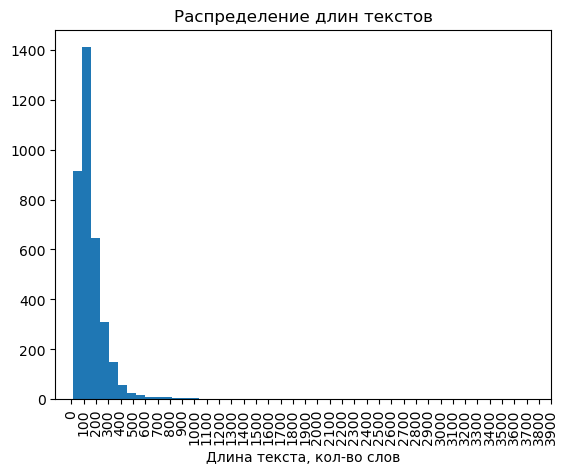

In [32]:
pd.Series([len(str(i).split()) for i in X_train]).hist(bins=40)

plt.xticks(np.arange(0, 4000, 100), rotation='vertical')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста, кол-во слов')
plt.grid()
plt.show()

In [33]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 500 # dimension of word embeddings
lstm_units = 32 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [34]:
# Save tokenizer for further usage in production
with open('tokenizers/ind_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))

In [38]:
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(clipvalue=0.7),
              metrics=[tfa.metrics.F1Score(num_classes=num_classes)])

scheduler = keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-5, decay_rate=0.85, decay_steps=100)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          5000000   
                                                                 
 lstm (LSTM)                 (None, 32)                68224     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 5068323 (19.33 MB)
Trainable params: 5068323 (19.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights = {i: weight for i, weight in enumerate(weights)}

print(weights)

{0: 6.659663865546219, 1: 0.3704136480486095, 2: 6.659663865546219}


In [40]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=11,
          callbacks=[scheduler],
          class_weight=weights,
          validation_data=(X_test, y_test))

Epoch 1/11
112/112 [==============================] - 58s 483ms/step - loss: 1.0982 - f1_score: 0.2602 - val_loss: 1.0861 - val_f1_score: 0.3082 - lr: 5.0000e-05
Epoch 2/11
112/112 [==============================] - 51s 458ms/step - loss: 1.0871 - f1_score: 0.4018 - val_loss: 1.0771 - val_f1_score: 0.3419 - lr: 4.9919e-05
Epoch 3/11
112/112 [==============================] - 53s 474ms/step - loss: 1.0739 - f1_score: 0.5070 - val_loss: 1.0623 - val_f1_score: 0.3479 - lr: 4.9838e-05
Epoch 4/11
112/112 [==============================] - 51s 460ms/step - loss: 1.0543 - f1_score: 0.5704 - val_loss: 1.0391 - val_f1_score: 0.3577 - lr: 4.9757e-05
Epoch 5/11
112/112 [==============================] - 53s 473ms/step - loss: 1.0154 - f1_score: 0.6359 - val_loss: 0.9441 - val_f1_score: 0.3653 - lr: 4.9676e-05
Epoch 6/11
112/112 [==============================] - 61s 547ms/step - loss: 0.9213 - f1_score: 0.5410 - val_loss: 0.8189 - val_f1_score: 0.3634 - lr: 4.9595e-05
Epoch 7/11
112/112 [========

In [41]:
model.save('artifacts/ind/ind_model.keras')

In [42]:
keras.models.load_model('artifacts/ind/ind_model.keras')

# Model for the global

In [10]:
df_glob = data_import_from_db('global_trade', conn_string)

## Preprocessing

In [24]:
preprocess_and_save(df_glob, 'glob')

  0%|          | 0/13304 [00:00<?, ?it/s]

In [90]:
df_glob = pd.read_csv('texts_glob.csv')

for i, text in enumerate(df_glob.text_clear):
    df_glob.loc[i, 'text_clear'] = prepare_text(text).strip()

In [91]:
df_glob = define_classes(df_glob, 'imoex_price_diff_percent', 'imoex_price_diff_cat', 0.05)
df_glob = define_classes(df_glob, 'rvi_price_diff_percent', 'rvi_price_diff_cat', 0.05)
df_glob = define_classes(df_glob, 'usd_price_diff_percent', 'usd_price_diff_cat', 0.05)

imoex_price_diff_cat
1    11972
0      666
2      666
Name: count, dtype: int64
rvi_price_diff_cat
1    11972
0      666
2      666
Name: count, dtype: int64
usd_price_diff_cat
1    11972
0      666
2      666
Name: count, dtype: int64


## Models 

### Model MOEX

In [92]:
texts = df_glob['text_clear']
labels = df_glob['imoex_price_diff_cat']

X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=labels)

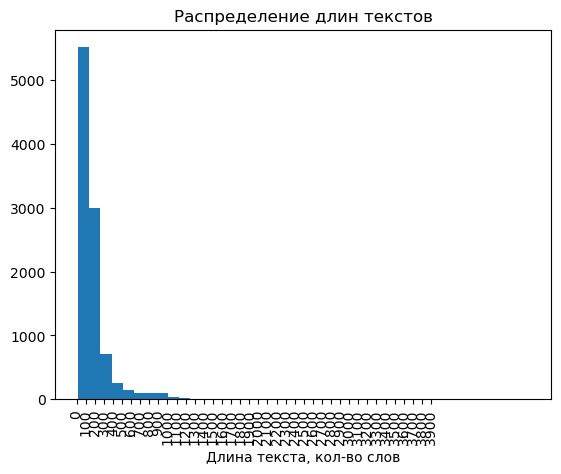

In [93]:
pd.Series([len(str(i).split()) for i in X_train]).hist(bins=40)

plt.xticks(np.arange(0, 4000, 100), rotation='vertical')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста, кол-во слов')
plt.grid()
plt.show()

In [94]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 500 # dimension of word embeddings
lstm_units = 32 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [95]:
# Save tokenizer for further usage in production
with open('tokenizers/glob_moex_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))

In [96]:
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(clipvalue=0.7),
              metrics=[tfa.metrics.F1Score(num_classes=num_classes)])

scheduler = keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_rate=0.85, decay_steps=100)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          5000000   
                                                                 
 lstm (LSTM)                 (None, 32)                68224     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 5068323 (19.33 MB)
Trainable params: 5068323 (19.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights = {i: weight for i, weight in enumerate(weights)}

print(weights)

{0: 6.658658658658658, 1: 0.37041986858224746, 2: 6.658658658658658}


In [46]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=10,
          callbacks=[scheduler],
          class_weight=weights,
          validation_data=(X_test, y_test))

Epoch 1/10
312/312 [==============================] - 165s 518ms/step - loss: 1.0983 - f1_score: 0.2507 - val_loss: 1.0937 - val_f1_score: 0.2670 - lr: 1.0000e-05
Epoch 2/10
312/312 [==============================] - 163s 522ms/step - loss: 1.0955 - f1_score: 0.3017 - val_loss: 1.0913 - val_f1_score: 0.2870 - lr: 9.9838e-06
Epoch 3/10
312/312 [==============================] - 170s 544ms/step - loss: 1.0927 - f1_score: 0.3479 - val_loss: 1.0883 - val_f1_score: 0.3073 - lr: 9.9675e-06
Epoch 4/10
312/312 [==============================] - 166s 532ms/step - loss: 1.0895 - f1_score: 0.3877 - val_loss: 1.0850 - val_f1_score: 0.3224 - lr: 9.9514e-06
Epoch 5/10
312/312 [==============================] - 164s 526ms/step - loss: 1.0860 - f1_score: 0.4214 - val_loss: 1.0808 - val_f1_score: 0.3330 - lr: 9.9352e-06
Epoch 6/10
312/312 [==============================] - 168s 540ms/step - loss: 1.0819 - f1_score: 0.4448 - val_loss: 1.0752 - val_f1_score: 0.3434 - lr: 9.9191e-06
Epoch 7/10
312/312 [==

In [99]:
model.save('artifacts/glob/glob_moex_model.keras')

In [100]:
keras.models.load_model('artifacts/glob/glob_moex_model.keras')

### Model RVI

In [49]:
texts = df_glob['text_clear']
labels = df_glob['rvi_price_diff_cat']

X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=labels)

In [50]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 500 # dimension of word embeddings
lstm_units = 32 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [51]:
# Save tokenizer for further usage in production
with open('tokenizers/glob_rvi_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))

In [52]:
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(clipvalue=0.7),
              metrics=[tfa.metrics.F1Score(num_classes=num_classes)])

scheduler = keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=3e-5, decay_rate=0.85, decay_steps=100)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          5000000   
                                                                 
 lstm (LSTM)                 (None, 32)                68224     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 5068323 (19.33 MB)
Trainable params: 5068323 (19.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights = {i: weight for i, weight in enumerate(weights)}

print(weights)

{0: 6.658658658658658, 1: 0.37041986858224746, 2: 6.658658658658658}


In [54]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=5,
          callbacks=[scheduler],
          class_weight=weights,
          validation_data=(X_test, y_test))

Epoch 1/5
312/312 [==============================] - 238s 750ms/step - loss: 1.0976 - f1_score: 0.2727 - val_loss: 1.0876 - val_f1_score: 0.3148 - lr: 3.0000e-05
Epoch 2/5
312/312 [==============================] - 259s 830ms/step - loss: 1.0894 - f1_score: 0.3607 - val_loss: 1.0811 - val_f1_score: 0.3257 - lr: 2.9951e-05
Epoch 3/5
312/312 [==============================] - 238s 763ms/step - loss: 1.0793 - f1_score: 0.4221 - val_loss: 1.0687 - val_f1_score: 0.3398 - lr: 2.9903e-05
Epoch 4/5
312/312 [==============================] - 225s 720ms/step - loss: 1.0630 - f1_score: 0.4753 - val_loss: 1.0413 - val_f1_score: 0.3472 - lr: 2.9854e-05
Epoch 5/5
312/312 [==============================] - 228s 732ms/step - loss: 1.0269 - f1_score: 0.5201 - val_loss: 0.8960 - val_f1_score: 0.3608 - lr: 2.9806e-05


In [55]:
model.save('artifacts/glob/glob_rvi_model.keras')

In [56]:
keras.models.load_model('artifacts/glob/glob_rvi_model.keras')

### Model RUBUSD

In [63]:
texts = df_glob['text_clear']
labels = df_glob['usd_price_diff_cat']

X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=labels)

In [64]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 500 # dimension of word embeddings
lstm_units = 32 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [65]:
# Save tokenizer for further usage in production
with open('tokenizers/glob_rubusd_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))

In [85]:
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(clipvalue=0.7),
              metrics=[tfa.metrics.F1Score(num_classes=num_classes)])

scheduler = keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=3e-5, decay_rate=0.85, decay_steps=100)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          5000000   
                                                                 
 lstm (LSTM)                 (None, 32)                68224     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 5068323 (19.33 MB)
Trainable params: 5068323 (19.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights = {i: weight for i, weight in enumerate(weights)}

print(weights)

{0: 6.658658658658658, 1: 0.37041986858224746, 2: 6.658658658658658}


In [87]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=5,
          callbacks=[scheduler],
          class_weight=weights,
          validation_data=(X_test, y_test))

Epoch 1/5
312/312 [==============================] - 246s 778ms/step - loss: 1.0988 - f1_score: 0.3065 - val_loss: 1.0829 - val_f1_score: 0.3301 - lr: 3.0000e-05
Epoch 2/5
312/312 [==============================] - 239s 768ms/step - loss: 1.0908 - f1_score: 0.3913 - val_loss: 1.0761 - val_f1_score: 0.3358 - lr: 2.9951e-05
Epoch 3/5
312/312 [==============================] - 236s 755ms/step - loss: 1.0803 - f1_score: 0.4589 - val_loss: 1.0625 - val_f1_score: 0.3434 - lr: 2.9903e-05
Epoch 4/5
312/312 [==============================] - 236s 757ms/step - loss: 1.0581 - f1_score: 0.5098 - val_loss: 0.9994 - val_f1_score: 0.3533 - lr: 2.9854e-05
Epoch 5/5
312/312 [==============================] - 234s 749ms/step - loss: 0.9992 - f1_score: 0.5107 - val_loss: 0.9302 - val_f1_score: 0.3576 - lr: 2.9806e-05


In [88]:
model.save('artifacts/glob/glob_rubusd_model.keras')

In [89]:
keras.models.load_model('artifacts/glob/glob_rubusd_model.keras')

# Upgraded tables save

In [75]:
def push_new_table_to_db(df, table_name, conn_string):
    db = create_engine(conn_string) 
    conn = db.connect() 
    conn.autocommit = True
    df.to_sql(table_name, con=conn, if_exists='replace', index=False) 
    conn.close()

In [76]:
push_new_table_to_db(df_comp, 'companies_trade_clear', conn_string)
push_new_table_to_db(df_ind, 'industries_trade_clear', conn_string)
push_new_table_to_db(df_glob, 'global_trade_clear', conn_string)

In [77]:
# Check 1
data_import_from_db('companies_trade_clear', conn_string)

,website,section,url,header,body,tags,body_length,datetime,company,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,text_clear,price_diff_cat
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,SBER,142.75,11917688.40,142.62,2958789.90,-0.13,-0.091068,-8958898.5,-75.173122,порядок филиал исламский банкинг мочь дополнит...,1
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,GAZP,163.13,1100961.10,163.37,1413064.30,0.24,0.147122,312103.2,28.348250,объмый экспорт газпром пройти год снизиться ми...,1
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,ROSN,363.70,178263.05,364.85,321423.75,1.15,0.316195,143160.7,80.308679,правительство рф предоставить ямальский шельфо...,1
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,SBER,141.31,1573757.40,141.40,2401025.00,0.09,0.063690,827267.6,52.566399,минувший год запомниться инвестор время высоки...,1
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,GAZP,161.69,4620114.20,161.60,1373716.00,-0.09,-0.055662,-3246398.2,-70.266622,минувший год запомниться инвестор время высоки...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/951074.php,Аналитики Домклик Сбера: в сентябре 2023г боле...,Аналитики Домклик посчитали количество выдач л...,"['Сбербанк', 'Домклик', 'ипотека', 'ипотечное ...",1457,2023-10-17 15:19:00,SBER,270.57,46419415.30,269.98,9093523.40,-0.59,-0.218058,-37325891.9,-80.410086,аналитик домклик посчитать количество выдача л...,1
7263,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/951090.php,Темпы роста выручки X5 максимальные с 2017 год...,Чистая розничная выручка X5 Group за III кварт...,"['Х5 Retail Group', 'операционные результаты',...",1470,2023-10-17 15:50:00,FIVE,2380.50,228507.50,2384.50,357756.50,4.00,0.168032,129249.0,56.562257,чистый розничный выручка x group iii квартал г...,1
7264,РИА,Экономика,https://ria.ru/20231017/gaz-1903428772.html,Венгрия и Сербия пообещали Болгарии ответ на п...,Будапешт и Белград ответят на повышение плат...,"['Экономика', 'Россия', 'Венгрия', 'Сербия', '...",721,2023-10-17 18:13:00,GAZP,172.04,1367705.30,172.00,42397837.50,-0.04,-0.023250,41030132.2,2999.924925,будапешт белград ответить повышение плата тран...,1
7265,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926333,FESCO и Liaoning Port будут развивать перевозк...,- Транспортная группа FESCO (головная компан...,"['FESCO', 'ВМТП', 'ДВМП', 'Подмосковье', 'Кита...",918,2023-10-17 18:21:00,FESH,98.07,9807.00,98.70,118440.00,0.63,0.642398,108633.0,1107.708779,транспортный группа fesco группа компания порт...,2


In [78]:
# Check 2
data_import_from_db('industries_trade_clear', conn_string)

,website,section,url,header,body,tags,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,text_clear,price_diff_cat
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN,6307.20,1.680676e+07,6308.77,1.185410e+07,1.57,0.024892,-4.952657e+06,-29.468250,порядок филиал исламский банкинг мочь дополнит...,1
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG,5696.30,4.451181e+06,5696.72,4.605859e+06,0.42,0.007373,1.546786e+05,3.475002,объмый экспорт газпром пройти год снизиться ми...,1
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG,5655.65,3.325798e+06,5663.65,1.490555e+06,8.00,0.141451,-1.835243e+06,-55.182029,правительство рф предоставить ямальский шельфо...,1
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN,6298.36,7.394623e+06,6296.27,3.371524e+06,-2.09,-0.033183,-4.023099e+06,-54.405737,минувший год запомниться инвестор время высоки...,1
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXOG,5655.00,1.594030e+07,5647.93,1.358916e+06,-7.07,-0.125022,-1.458139e+07,-91.474969,минувший год запомниться инвестор время высоки...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4750,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926309,"СД ""Ростелекома"" рекомендовал дивиденды-2022 в...","- Совет директоров ПАО ""Ростелеком"" рекоменд...",['Ростелеком'],2096,2023-10-17 16:35:00,MOEXTL,2042.22,8.146566e+07,2041.61,2.950564e+07,-0.61,-0.029869,-5.196003e+07,-63.781504,совет директор пао ростелеком рекомендовать ак...,1
4751,РИА,Экономика,https://ria.ru/20231017/eksport-1903397700.html,ГД приняла в I чтении проект об экспорте СПГ б...,Госдума приняла в первом чтении законопроект...,"['Экономика', 'Газпром', 'Новатэк', 'Госдума Р...",1997,2023-10-17 17:09:00,MOEXOG,9157.44,3.539749e+07,9156.21,1.986335e+07,-1.23,-0.013432,-1.553413e+07,-43.884848,госдума принять первый чтение законопроект поз...,1
4752,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926319,"Принят в I чтении проект, разрешающий ""НОВАТЭК...",- Госдума РФ в первом чтении приняла законоп...,"['НОВАТЭК', 'Госдума']",3838,2023-10-17 17:17:00,MOEXOG,9155.69,1.499790e+07,9161.10,8.713726e+06,5.41,0.059089,-6.284177e+06,-41.900370,госдума рф первый чтение принять законопроект ...,1
4753,РИА,Экономика,https://ria.ru/20231017/gaz-1903428772.html,Венгрия и Сербия пообещали Болгарии ответ на п...,Будапешт и Белград ответят на повышение плат...,"['Экономика', 'Россия', 'Венгрия', 'Сербия', '...",721,2023-10-17 18:13:00,MOEXOG,9168.87,1.394318e+07,9169.17,1.687321e+07,0.30,0.003272,2.930027e+06,21.014044,будапешт белград ответить повышение плата тран...,1


In [79]:
# Check 3
data_import_from_db('global_trade_clear', conn_string)

,website,section,url,header,body,tags,body_length,datetime,imoex_price_release,imoex_price_lag_30,...,imoex_price_diff,imoex_price_diff_percent,rvi_price_diff,rvi_price_diff_percent,usd_price_diff,usd_price_diff_percent,text_clear,imoex_price_diff_cat,rvi_price_diff_cat,usd_price_diff_cat
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,2166.77,2168.03,...,1.26,0.058151,-0.19,-0.469716,-377.0,-0.535877,порядок филиал исламский банкинг мочь дополнит...,1,1,0
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00,2166.37,2167.18,...,0.81,0.037390,-0.20,-0.494438,-256.0,-0.364340,минпромторг прогнозировать наступить год увели...,1,1,0
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00,2166.08,2166.96,...,0.88,0.040626,-0.21,-0.519159,-159.0,-0.226573,рынок акция рф открыться вторник рост рублевый...,1,1,1
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00,2168.32,2168.95,...,0.63,0.029055,0.36,0.903161,93.0,0.132760,подведомственный минпромторг фгуп передавать а...,1,1,1
4,РИА,Экономика,https://ria.ru/20230103/kazakhstan-1842940182....,Путин и Токаев обменялись по телефону поздравл...,Владимир Путин и президент Казахстана Касым-...,"['Владимир Путин', 'Касым-Жомарт Токаев', 'В м...",752,2023-01-03 14:20:00,2169.06,2169.46,...,0.40,0.018441,0.72,1.836735,-104.0,-0.145518,владимир путин президент казахстан касымжомарт...,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13299,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926333,FESCO и Liaoning Port будут развивать перевозк...,- Транспортная группа FESCO (головная компан...,"['FESCO', 'ВМТП', 'ДВМП', 'Подмосковье', 'Кита...",918,2023-10-17 18:21:00,3249.29,3247.15,...,-2.14,-0.065861,-0.08,-0.304646,-29.0,-0.029417,транспортный группа fesco группа компания порт...,1,1,1
13300,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926338,Аналитики ЦБ отметили в сентябре новый импульс...,- Экономическая активность в России в целом ...,"['Банк России', 'Минэкономразвития']",2351,2023-10-17 18:33:00,3252.16,3247.15,...,-5.01,-0.154051,0.38,1.472868,-103.0,-0.104403,экономический активность россия целое оставать...,1,1,1
13301,РИА,Экономика,https://ria.ru/20231017/zernovye-1903437148.html,В этом году Россия поставила миллион тонн зерн...,Россия в текущем году уже поставила миллион ...,"['Россия', 'Пакистан', 'Владимир Путин', 'Экон...",224,2023-10-17 18:46:00,3247.15,3246.91,...,-0.24,-0.007391,0.17,0.649351,9.0,0.009130,россия текущий год поставить миллион тонна зер...,1,1,1
13302,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926342,Инфляция в России может превысить прогноз ЦБ в...,В ЦБ отметили преобладание проинфляционных рис...,['Банк России'],1841,2023-10-17 18:56:00,3246.83,3247.89,...,1.06,0.032647,2.56,10.130590,105.0,0.106534,цб отметить преобладание проинфляционный риск ...,1,2,1
